In [1]:
import librosa
import time
import pandas as pd
import numpy as np
import os

from pathlib import Path
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import csv
import IPython.display as ipd
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
from keras import models
from keras import layers
from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

from collections import Counter

import mo_tf
import timeit
from openvino.inference_engine import IECore

In [2]:
# reading dataset from csv
stat = 'abnormal normal'.split()
data_origin = pd.read_csv('data_00.csv')
data = data_origin.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.332487,0.012099,1180.264031,1579.000699,2220.767700,0.049593,-383.320099,177.115570,-30.398430,43.175835,...,9.741942,17.725452,-5.918385,10.031418,-17.544346,7.334301,-7.061300,10.523767,3.254827,abnormal
1,0.497902,0.013013,1036.513080,1375.484191,2200.808270,0.037650,-370.949249,186.253677,-39.915035,60.632927,...,-2.551307,6.779550,-5.985898,7.088058,-6.116435,8.007307,-1.762496,2.309028,-1.095314,abnormal
2,0.325402,0.012418,1271.447206,1735.250822,2644.712005,0.049436,-376.357697,167.325989,-21.110481,45.520447,...,-3.114837,8.503551,-5.267240,17.415310,-7.076010,16.206793,-4.685070,0.707447,-11.416034,abnormal
3,0.474146,0.010462,1050.479779,1347.219254,2201.532705,0.044327,-381.908417,190.770233,-44.368759,61.062855,...,-3.054621,7.736747,-4.699168,8.208503,-6.886340,6.885895,-3.381184,1.034102,-2.435584,abnormal
4,0.329252,0.009813,1414.325444,1763.148493,3041.902178,0.066287,-371.388824,164.614594,-29.966749,51.685932,...,-4.580791,-2.014683,-10.503709,15.157179,-7.044686,18.311527,-1.110782,9.126927,-10.090671,abnormal


In [3]:
sound_list = data.iloc[:, -1]
encoder = LabelEncoder()
y_origin = encoder.fit_transform(sound_list)
y = [1 if e == 0 else 0 for e in y_origin]
y = np.array(y)

In [4]:
# normalizing
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [5]:
# spliting of dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [6]:
X_train_norm = X_train[y_train == 0]
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_norm.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(X_train_norm.shape[1], activation=None))

2022-04-13 11:20:10.485415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Compile and train the model

In [7]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1728      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 64)                576       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 26)                1690      
                                                                 
Total params: 12,834
Trainable params: 12,834
Non-traina

In [9]:
checkpointer = callbacks.ModelCheckpoint(filepath="AE_weights.hdf5", verbose=0, save_best_only=True)

epochs = 100

history = model.fit(X_train_norm, X_train_norm, epochs=epochs, batch_size=512, shuffle=True, validation_split=0.1, verbose=0, callbacks=[checkpointer])

In [10]:
model.load_weights('AE_weights.hdf5')

# Visualize training results

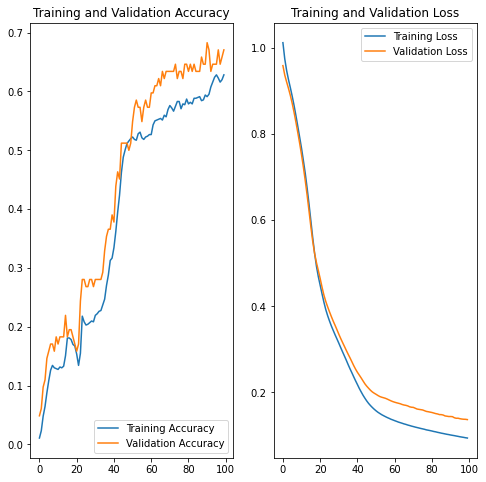

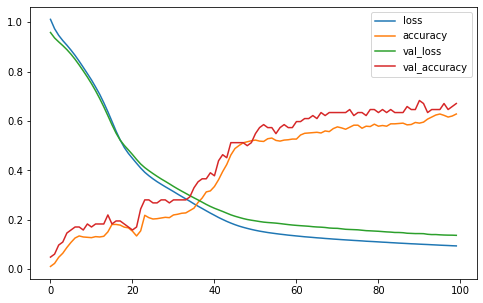

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [12]:
y_pred_proba = np.mean(np.square(X_train_norm - model.predict(X_train_norm)), axis=1)
threshold = np.percentile(y_pred_proba, 80)

In [13]:
y_pred_proba = np.mean(np.square(X_test - model.predict(X_test)), axis=1)
y_pred = [1 if e > threshold else 0 for e in y_pred_proba]

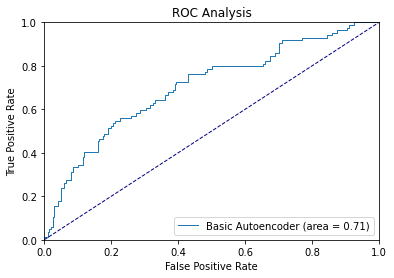

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr,
         lw=lw, label='Basic Autoencoder (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Analysis')
plt.legend(loc="lower right")
plt.show()

# Save the TensorFlow Model

In [15]:
model_fname="saved_model"
model.save(model_fname)

2022-04-13 11:20:17.178724: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


In [16]:
input_shape = [1, (X_train.shape[1])]

In [17]:
input_shape

[1, 26]

# Convert the TensorFlow model with OpenVINO Model Optimizer

In [18]:
# The paths of the source and converted models
model_name = "saved_model"
model_path = Path(model_name)
ir_data_type = "FP16"
ir_model_name = "model_ir"

# Get the path to the Model Optimizer script
mo_path = str(Path(mo_tf.__file__))

# Construct the command for Model Optimizer
mo_command = f""""{sys.executable}"
                 "{mo_path}" 
                 --saved_model_dir "{model_name}"
                 --input_shape "{input_shape}" 
                 --data_type "{ir_data_type}" 
                 --output_dir "{model_path.parent}"
                 --model_name "{ir_model_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
print(mo_command)

Model Optimizer command to convert TensorFlow to OpenVINO:
"/opt/anaconda3/bin/python3.7" "/opt/anaconda3/lib/python3.7/site-packages/mo_tf.py" --saved_model_dir "saved_model" --input_shape "[1, 26]" --data_type "FP16" --output_dir "." --model_name "model_ir"


In [19]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/Users/jamesmurphy/Desktop/Folders/PhD Project/Projects/MIMII/.
	- IR output name: 	model_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1, 26]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation: 	None
	- Update the configuration file with input

# OpenVINO Inference Engine Setup

In [20]:
ie = IECore()
ie.available_devices

['CPU']

In [21]:
class_names=["abnormal", "normal"]

model_xml = "model_ir.xml"
model_bin = "model_ir.bin"

# Load network to the plugin
ie = IECore()
net = ie.read_network(model=model_xml, weights=model_bin)

# Neural Compute Stick
exec_net = ie.load_network(network=net, device_name=ie.available_devices[1])
#exec_net = ie.load_network(network=net, device_name="CPU")

del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

IndexError: list index out of range

# Run the Inference Step for NCS

In [ ]:
file_no = 0
input_wav = X_test[file_no]

res = exec_net.infer(inputs={input_layer: input_wav})
res = res[output_layer]

y_pred_proba = np.mean(np.square(input_wav - res[0]))
y_pred = [1 if y_pred_proba > threshold else 0]

# actual status
r = y_test[file_no]
print('Actual Status: ',stat[r])
value = np.where(X == X_test[file_no:(file_no+1)])
new = data_origin.to_numpy()
name = new[value[0][0]][0]
if stat[r] == class_names[y_pred[0]]:
    print("\nResult: Correct!")
else:
    print("\nResult: Incorrect!")

In [ ]:
out = []

def infer():
    for input_wav in X_test:
        res = exec_net.infer(inputs={input_layer: input_wav})
        res = res[output_layer]
        out.append(res)

itter = 10
total_time = (timeit.timeit(infer, number = itter)/itter)*1000
infer_time_ncs = (total_time / len(X_test))

print('Total Time for ' + str(len(X_test)) + ' Objects: ' + str(round(total_time, 2)) + 'ms')
print('Individual Inferrence Time ' + str(round(infer_time_ncs, 2)) + 'ms')

# Run the Inference Step for CPU

In [ ]:
net = ie.read_network(model=model_xml, weights=model_bin)

# Neural Compute Stick
exec_net = ie.load_network(network=net, device_name=ie.available_devices[0])

del net

input_layer = next(iter(exec_net.input_info))
output_layer = next(iter(exec_net.outputs))

In [ ]:
out = []

def infer():
    for input_wav in X_test:
        res = exec_net.infer(inputs={input_layer: input_wav})
        res = res[output_layer]
        out.append(res)

itter = 10
total_time = (timeit.timeit(infer, number = itter)/itter)*1000
infer_time_cpu = (total_time / len(X_test))

print('Total Time for ' + str(len(X_test)) + ' Objects: ' + str(round(total_time, 2)) + 'ms')
print('Individual Inferrence Time ' + str(round(infer_time_cpu, 2)) + 'ms')

# Compare Runtimes

In [ ]:
dif = infer_time_ncs - infer_time_cpu
times = infer_time_ncs / infer_time_cpu

print('Inferrence Times\n\n')
print(ie.available_devices[1] + ' Inferrence Time: ' + str(round(infer_time_ncs, 2)) + 'ms')
print(ie.available_devices[0] + ' Inferrence Time: ' + str(round(infer_time_cpu, 2)) + 'ms')
print('\nInferrence Time Difference: ' + str(round(dif, 2)) + 'ms')
print(ie.available_devices[0] + ' is ' + str(round(times, 2)) + ' times faster than ' + ie.available_devices[1])

In [ ]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
reconstructions = model.predict(X_train_norm)
train_loss = tf.keras.losses.mae(reconstructions, X_train_norm)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(model, X_test, threshold)
print_stats(preds, y_test)